In [68]:
from datetime import datetime, date, time, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from utils import *
from median_optimization import optimal_median

In [69]:
TRAIN_START = "2023-10-02 00:00"
TRAIN_END = "2023-12-03 23:59"


TEST_START = "2023-12-04 00:00"
TEST_END = "2023-12-10 23:59"
test_rain_dates = []

PUBLIC_START = "2023-10-21 00:00"
PUBLIC_END = "2023-10-24 23:59"
public_rain_dates = []

PRIVATE_START = "2023-12-18 00:00"
PRIVARE_END = "2023-12-24 23:59"
private_rain_dates = [date(2023, 12, 19), date(2023,12,20)]


In [106]:
with open("./cache/small_data_cache.pkl", "rb") as f:
    df = pd.read_pickle(f)
with open("../html.2023.final.data/sno_test_set.txt") as f:
    ntu_snos = [l.strip() for l in f.read().splitlines()]
with open("./cache/1003-1222_rain.pkl","rb") as f:
    rain_df = pd.read_pickle(f)

ntu_snos = ['500119048','500119083']

In [71]:
ntu_tots = get_tot(df, ntu_snos)

holidays = [d for d in date_range(start=TRAIN_START, end=PRIVARE_END) if is_holiday(d)]

In [107]:
df['datehour'] = df['time'].dt.floor("H")
rain_df.rename(columns={'datetime':'datehour'},inplace=True)

df = df.merge(rain_df,on='datehour',how='left')
df['rain'].fillna(0,inplace=True)
print(df)
df.describe()

                        time        sno  tot  sbi act            datehour  \
0        2023-10-02 00:00:00  500101001   28   12   1 2023-10-02 00:00:00   
1        2023-10-02 00:01:00  500101001   28   12   1 2023-10-02 00:00:00   
2        2023-10-02 00:02:00  500101001   28   13   1 2023-10-02 00:00:00   
3        2023-10-02 00:03:00  500101001   28   13   1 2023-10-02 00:00:00   
4        2023-10-02 00:04:00  500101001   28   13   1 2023-10-02 00:00:00   
...                      ...        ...  ...  ...  ..                 ...   
12523387 2023-12-26 23:55:00  500119091   18    7   1 2023-12-26 23:00:00   
12523388 2023-12-26 23:56:00  500119091   18    7   1 2023-12-26 23:00:00   
12523389 2023-12-26 23:57:00  500119091   18    7   1 2023-12-26 23:00:00   
12523390 2023-12-26 23:58:00  500119091   18    7   1 2023-12-26 23:00:00   
12523391 2023-12-26 23:59:00  500119091   18    7   1 2023-12-26 23:00:00   

          rain  
0          0.0  
1          0.0  
2          0.0  
3      

,tot,sbi,rain
count,1.252339e+07,1.252339e+07,1.252339e+07
mean,2.578912e+01,7.856634e+00,1.353375e-01
std,1.701765e+01,1.050669e+01,5.905960e-01
min,5.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,1.000000e+00,0.000000e+00
50%,2.000000e+01,4.000000e+00,0.000000e+00
75%,3.000000e+01,1.100000e+01,0.000000e+00
max,9.900000e+01,9.900000e+01,9.000000e+00


In [108]:
morning_filter = (df["datehour"].dt.hour >= 7) & (df['datehour'].dt.hour <= 21)
rain_hours = df['datehour'][ (df["sno"] == "500101001") & morning_filter &(df['rain'] >= 0.3) ].drop_duplicates() # 0.3 for dribble , 0.5 for small rain
rain_dates = rain_hours.dt.date.drop_duplicates()

#print(rain_dates.describe()) # 0.3: 28, 0.5: 15 total:63-62 days

date_rain_hour_cnt = rain_hours.dt.date.value_counts()
#print(date_rain_hour_cnt)

In [109]:
long_rain_dates = rain_dates[rain_dates.isin(date_rain_hour_cnt.index[date_rain_hour_cnt >= 7])]
#print(long_rain_dates) # 12
#print(long_rain_dates.describe())
rainy_dates = long_rain_dates.array # 12
print(rainy_dates)

<PandasArray>
[ datetime.date(2023, 10, 3),  datetime.date(2023, 10, 4),
  datetime.date(2023, 10, 5), datetime.date(2023, 10, 20),
 datetime.date(2023, 11, 10), datetime.date(2023, 11, 12),
 datetime.date(2023, 11, 14), datetime.date(2023, 11, 16),
 datetime.date(2023, 11, 24), datetime.date(2023, 11, 25),
 datetime.date(2023, 11, 26), datetime.date(2023, 11, 29),
 datetime.date(2023, 11, 30),  datetime.date(2023, 12, 1),
  datetime.date(2023, 12, 4),  datetime.date(2023, 12, 5),
  datetime.date(2023, 12, 6), datetime.date(2023, 12, 17),
 datetime.date(2023, 12, 21)]
Length: 19, dtype: object


delete rain processing variables

In [110]:
del rain_df
del morning_filter
del rain_hours, rain_dates
del date_rain_hour_cnt
del long_rain_dates

Only one main table. Then always slice from it

In [111]:
#old_tb = pd.pivot_table(df, index="time", columns="sno", values="sbi") # for patching
tb = (
    pd.pivot_table(df, index="time", columns="sno", values="sbi")
    .resample("20min")
    .first()
)
# exclude long holidays
#tb_rainy = tb[~tb.index.to_series().dt.date.isin(long_holiday)]
#tb_sunny = tb_rainy[~tb_rainy.index.to_series().dt.date.isin(rainy_dates)]
# [] only provides view,so assigning to it cause warning


Training

In [77]:
def prep_train_data(tb)->pd.DataFrame:
    train = tb[tb.index.to_series().dt.date.isin(date_range(TRAIN_START, TRAIN_END))].copy()
    train.reset_index(names="time", inplace=True)
    train["weekday"] = train["time"].dt.weekday
    train.set_index(["time", "weekday"], inplace=True)
    return train

def prep_sd_data(train,sno)->pd.DataFrame:
    sd = train[sno].to_frame()
    sd.rename(columns={sno: "sbi"}, inplace=True)
    sd.reset_index(["time", "weekday"], inplace=True)
    sd["date"] = sd["time"].dt.date
    sd["time"] = sd["time"].dt.time
    sd = pd.pivot_table(sd, index=["date", "weekday"], columns="time", values="sbi")
    return sd

#def trans(s):
#    if s in range(5):
#        return 0
#    return s

sd:
```
time                	00:00:00  00:20:00  00:40:00  01:00:00  01:20:00  ...
date       weekday 		sbi
```

Training data

In [78]:
train = prep_train_data(tb)

result_df = pd.DataFrame(
            columns=ntu_snos,
            index=pd.MultiIndex.from_product(
                [[True,False],pd.date_range("00:00", "23:59", freq="20min").time, [d for d in range(7)]],
                names=("rain","time", "weekday"),
            ),
            dtype=np.float64,
        )
        
Ein={True:0.0,False:0.0} # rain

from matplotlib import legend


def plot(sd,sno):
    dsd = sd.droplevel('weekday')
    tsd = dsd.T
    rain_filter = dsd.index.to_series().isin(rainy_dates)
    trdsd = dsd[rain_filter].T
    tsdsd = dsd[~rain_filter].T

    #ax = trdsd.plot(color="blue", lw=0.8,  legend=False)
    #ax = tsdsd.plot(ax=ax, color="green", lw=0.3, alpha=0.8,  legend=False)
    
    #std = tsd.std(axis=1)
    #ax = std.plot(ax=ax, color="orange", legend=False)
    
    # sunny weekday avg
    twsdsd = sd[(~rain_filter).values].droplevel('date').groupby(level=0).mean().T
    twsdsd.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    mon = twsdsd['Mon']
    twsdsd.drop(columns=['Mon','Sat','Sun'],inplace=True)
    #mean = twsdsd.mean(axis=1)
    #mean.name = 'Mean'
    #ax = mean.plot(ax=ax, color="red", lw=2)
    #ax = mean.plot(color="red", lw=2,legend=True)
    #twsdsd.drop(columns=['Sat','Sun'],inplace=True)
    ax = mon.plot(color='red',lw=2,legend=True)
    ax = twsdsd.plot(ax=ax, color='blue', lw=2)

    #plt.savefig(f"./week_rain_lines/{sno}.png")
    plt.show()
    #plt.close(ax.get_figure())

for sno in ntu_snos:
    plot(prep_sd_data(train,sno),sno)

In [79]:
from scipy.spatial.distance import euclidean
def find_specials(sd):
    grouped_stats = sd.droplevel('date').groupby(level=0).mean().drop([5, 6]).T
    time_series_data = grouped_stats.iloc[:, :5].values.T
    # Initialize an empty distance matrix
    distance_matrix = np.zeros((5, 5))

    for i in range(5):
        for j in range(i):
            distance = euclidean(time_series_data[i], time_series_data[j])
            distance_matrix[i][j] = distance_matrix[j][i]= distance
            #print(f"{i} vs {j}")
            #print(distance)
            #print(path)
    #print(distance_matrix)
    means = np.mean(distance_matrix, axis=1)
    std=  np.std(means)
    mean = np.mean(means)
    #cv = std/mean
    specials=[]
    for i in range(5):
        if np.abs(means[i] - mean) > 1.7 * std:
            specials.append(i)
    #print(f"means: {means}")
    #print(f"mean: {mean}")
    #print(f"std: {std}")
    return specials
    #print(f"cv: {std/mean}")
    
    # do classification

for sno in ntu_snos:
    print(find_specials(prep_sd_data(train,sno)))

In [80]:
def first_greater_prefix_sum_idx(arr, target):
    prefix_sum = 0

    for i, element in enumerate(arr):
        prefix_sum += element

        if prefix_sum > target:
            return i

def optimal_median_exp(y_true_df: pd.DataFrame, tot: int) -> tuple[np.float64, np.float64]:
    #print(y_true_df)
    alpha = 0.2
    r = 1/(1-alpha)
    # assert len(y_true.shape) == 1, "optimal_median: shape error"
    # print(f"y_true: {y_true}")
    y_true_df.dropna(inplace=True)
    y_true_df["s"] = r**y_true_df["nweek"]
    y_true_df.sort_values("sbi",inplace=True)
    #print(y_true_df)
    y_sorted = y_true_df["sbi"].to_numpy()
    s = y_true_df["s"].to_numpy()
    #nan_indices = np.isnan(y_true)
    # Use boolean indexing to drop NaN values
    #y_true = y_true[~nan_indices]

    arr_len = y_sorted.shape[0]
    tots = np.full(arr_len, tot)

    # generalized median
    #y_sorted = np.sort(y_true)
    weight = np.abs(y_sorted / tot - 1 / 3) + np.abs(y_sorted / tot - 2 / 3)
    weight = weight * s
    w_mid = np.sum(weight) / 2
    #w_cur = 0

    # if odd, first > w_mid
    # if even, before m1 must less than w_mid, m2 must greater than w_mid
    best_sbi = y_sorted[first_greater_prefix_sum_idx(weight, w_mid)]
    best_err = error(y_sorted, np.full(arr_len, best_sbi), tots)

    return best_sbi, best_err

In [81]:
for sno, tot in zip(ntu_snos, ntu_tots): # column as 0-th index
    #station data
    sd = prep_sd_data(train,sno)
    
    specials = find_specials(sd)+[5,6]
    normal = [d for d in range(7) if d not in specials]
    # print(f"{sno} specials: {specials}")
    # TODO prepare drawing
    for rain in [True,False]:
        if not rain:
            sd = sd[~sd.index.get_level_values("date").isin(rainy_dates)]
        
        # classify dates
        for day in specials:
            for t in sd.columns: # t is time
                # print(t, sno)
                y_true = sd.loc[sd.index.get_level_values("weekday") == day, [t]]
                y_true.dropna(inplace=True)
                y_true.rename(columns={t:"sbi"},inplace=True)
                # drop weekday index from y_true#
                y_true.index = y_true.index.droplevel("weekday")
                # compute the date difference between y_true and 10/2
                y_true["nweek"] = (y_true.index - date(2023, 10, 2)).days//7
                #print(y_true)
                sbi, err = optimal_median_exp(
                    y_true_df=y_true,
                    tot=tot,
                )
                #sbi, err = optimal_median(
                #    y_true=y_true.to_numpy(),
                #    tot=tot,
                #)
                Ein[rain] += err
                # print(f"{t} sbi:{sbi}   err: {err}")
                result_df.at[(rain, t, day), sno] = sbi
                # result_df.at[[t, isholiday], sno] = np.float64(sbi)
                # print(result_df.at[t, sno])
        
        # not specials
        for t in sd.columns:
            # print(t, sno)
            y_true = sd.loc[sd.index.get_level_values("weekday").isin(normal), [t]]
            y_true.dropna(inplace=True)
            y_true.rename(columns={t:"sbi"},inplace=True)
            # drop weekday index from y_true#
            y_true.index = y_true.index.droplevel("weekday")
            # compute the date difference between y_true and 10/2
            y_true["nweek"] = (y_true.index - date(2023, 10, 2)).days//7
            #print(y_true)
            sbi, err = optimal_median_exp(
                y_true_df=y_true,
                tot=tot,
            )
            # print(f"{t} sbi:{sbi}   err: {err}")
            for day in normal:
                result_df.at[(rain, t, day), sno] = sbi
                Ein[rain] += err
            # result_df.at[[t, isholiday], sno] = np.float64(sbi)
            # print(result_df.at[t, sno])

#print(result_df)
assert not result_df.isnull().values.any()
#print(result_df.xs(True).size)
#print(result_df.xs(False).size)
for rain in [True, False]:
    Ein[rain] /= result_df.xs(rain).size
    print(("All" if rain else "Sunny")+ f" Ein = {Ein[rain]}")

All Ein = 0.2789073484292012
Sunny Ein = 0.2771471544474237


#from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
for sno, tot in zip(ntu_snos, ntu_tots): # column as 0-th index
    #station data
    sd = prep_sd_data(train,sno)
    
    # TODO prepare drawing
    #for rain in [True,False]:
    #    if not rain:
    #        sd = sd[~sd.index.get_level_values("date").isin(rainy_dates)]
    #for t in sd.columns:

    grouped_stats = sd.droplevel('date').groupby(level=0).mean().drop([5, 6]).T
    
    print(sno)
    #print(grouped_stats)
    time_series_data = grouped_stats.iloc[:, :5].values.T
    print(time_series_data.shape)
    # Initialize an empty distance matrix
    distance_matrix = np.zeros((5, 5))

    # Calculate the distance between each pair of time series using DTW
    for i in range(5):
        for j in range(i):
            distance = euclidean(time_series_data[i], time_series_data[j])
            distance_matrix[i][j] = distance_matrix[j][i]= distance
            #print(f"{i} vs {j}")
            #print(distance)
            #print(path)
    print(distance_matrix)

    means = np.mean(distance_matrix, axis=1)
    std=  np.std(means)
    mean = np.mean(means)
    print("means:")
    print(means)
    print(f"mean: {mean}")
    print(f"std: {std}")
    print(f"cv: {std/mean}")
    #distance_matrix[3, 3] = distance
    #for i in range(5):
    #    for j in range(5):
    #        distance, path = fastdtw(time_series_data[i], time_series_data[j],dist=euclidean)
    #        distance_matrix[i, j] = distance
    #print(distance_matrix)


            sbi, err = optimal_median(
                y_true=sd.loc[
                    sd.index.get_level_values("weekday") == day, t
                ].to_numpy(),
                tot=tot,
            )
            Ein[rain] += err
            # print(f"{t} sbi:{sbi}   err: {err}")
            result_df.at[(rain, t, day), sno] = sbi
            # result_df.at[[t, isholiday], sno] = np.float64(sbi)
            # print(result_df.at[t, sno])

#assert not result_df.isnull().values.any()
#print(result_df.xs(True).size)
#print(result_df.xs(False).size)
for rain in [True, False]:
    Ein[rain] /= result_df.xs(rain).size
    print(("All" if rain else "Sunny")+ f" Ein = {Ein[rain]}")

(~12/15) \
All Ein = 0.3064290485258894 \
Sunny Ein = 0.12642283980395305

Self evaluation (Test)

In [112]:
test = tb[tb.index.to_series().dt.date.isin(date_range(TEST_START, TEST_END))]
y_test = test.values

print_time_ranges(TRAIN_START, TRAIN_END, TEST_START, TEST_END)


Train: 10/02 - 12/03
Test: 12/04 - 12/10


In [83]:
ftr = list(
    np.stack([test.index.to_series().dt.date.isin(rainy_dates),test.index.time, test.index.to_series().dt.weekday]).T
)
y_pred = result_df.loc[ftr].values
local_test_range = pd.date_range(TEST_START, TEST_END, freq="20min")
assert y_test.shape == y_pred.shape , "test pred shape not matched"
print(y_pred)
# print(y_test.shape) #
# print(y_pred.shape)

[[11.  3. 14. ...  0.  7.  1.]
 [10.  3. 14. ...  4.  7.  1.]
 [ 9.  4. 14. ...  4.  6.  2.]
 ...
 [ 2.  2. 15. ...  0.  9.  4.]
 [ 2.  1. 16. ...  0.  9.  3.]
 [10.  1. 16. ...  0.  9.  4.]]


(288, 112) \
(288, 112)

In [113]:
if result_df.isna().any().any():
    print("NaN detected")
if result_df.loc[ftr].isna().any().any():
    print("NaN detected in test")
if np.isnan(y_test).any():
    print("test contains NaN values")
    #print(np.isnan(y_test).sum())
    y_test = np.nan_to_num(y_test, copy=False)
if np.isnan(y_pred).any():
    print("pred contains NaN values")

MAE:  0.16819843316302552
Score:  0.2980640202244597


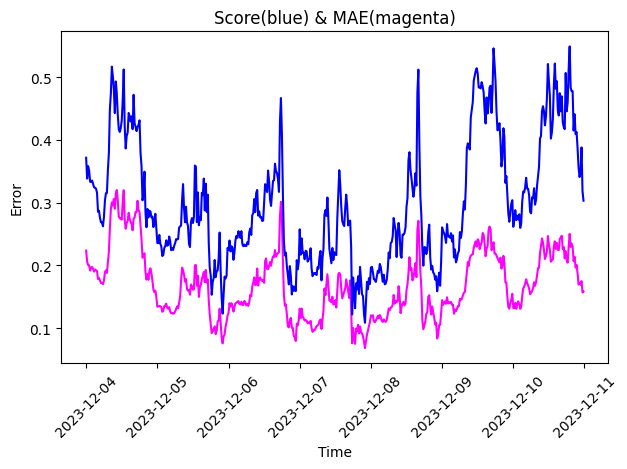

In [114]:
evaluation(y_test, y_pred, ntu_tots, local_test_range)


all sunny \
MAE:  0.13275823190272154 \
Score:  0.24003751756886713

all data \
MAE:  0.1229537906365303 \
Score:  0.21939612130515754

rain+sunny \
MAE:  0.12230290642321821 \
Score:  0.2167087889314868


does the same at public test set (2023/10/21 - 2023/10/24)

public_test_range = pd.date_range(PUBLIC_START, PUBLIC_END, freq="20min")
# list makes indexer 1D, or it is an 2D indexer
ftr = list(
    np.stack([[False]*(4*72),public_test_range.time, public_test_range.weekday]).T
)
y_public_df = result_df.loc[ftr]
#print("y_public_df Before")
#print(y_public_df)

Check public

#print("y_public_df After")
#print(y_public_df)

for col, tot in zip(y_public_df.columns, ntu_tots):
    y_public_df[col] = y_public_df[col].clip(lower=0, upper=tot)
y_public_test = y_public_df.values
public_test_df = pd.DataFrame(y_public_test, columns=ntu_snos, index=public_test_range)

private_test_range = pd.date_range(PRIVATE_START, PRIVARE_END, freq="20min")
ftr = list(
    np.stack(
        [[d in private_rain_dates for d in private_test_range.date],private_test_range.time, private_test_range.weekday]
    ).T
)
y_private_df = result_df.loc[ftr]

# TODO patch private
# Set the initial time
current_datetime = pd.to_datetime("2023-12-17 22:40")
current_time = current_datetime.time()
cur_data = tb[tb.index == current_datetime]
print(cur_data)
cur = tb[tb.index.to_series().dt.time == current_time]

# Loop to fetch data for the next 20 minutes
end_datetime = pd.to_datetime("2023-12-18 04:00")
next_datetime = current_datetime + timedelta(minutes=60)
td = timedelta(minutes=20)
total_td = timedelta(minutes=60)
while next_datetime <= end_datetime:
    # Increment current_time by 20 minutes
    next_datetime += td
    next_time = next_datetime.time()
    total_td += td
    # Filter data from tb for the current time
    nxt = tb[tb.index.to_series().dt.time == next_time]
    diff = nxt - cur.shift(freq=total_td)
    mean_diff = pd.pivot_table(diff.mean().reset_index(), columns="sno")
    mean_diff.set_index(cur_data.index, inplace=True)
    upd = cur_data + mean_diff
    print(upd)
    patch_datetime = next_datetime 
    patch_time = patch_datetime.time()
    print(patch_time)
    upd.set_index([[patch_time], [0]], inplace=True)
    y_private_df.loc[(patch_time, 0)] = upd

if y_private_df.isnull().values.any():
    print("DataFrame contains NaN values.")
print(y_private_df)

assert not y_private_df.isnull().values.any(), "private contains null"
for col, tot in zip(y_private_df.columns, ntu_tots):
    y_private_df[col] = y_private_df[col].clip(lower=0, upper=tot)
y_private_test = y_private_df.values
private_test_df = pd.DataFrame(
    y_private_test, columns=ntu_snos, index=private_test_range
)

tmp = pd.concat(
    [
        public_test_df,
        private_test_df,
    ]
)
# reset_index: old index => "time" column
# id_vars: fixed column like index
# var_name: columns.name to "sno" column
# value_name: value => "sbi" column
tmp = tmp.reset_index(names="time").melt(
    id_vars="time", var_name="sno", value_name="sbi"
)
out_df = pd.DataFrame(
    {
        "id": (
            tmp["time"].dt.strftime("%Y%m%d")
            + "_"
            + tmp["sno"]
            + "_"
            + tmp["time"].dt.strftime("%H:%M")
        ),
        "sbi": tmp["sbi"],
    }
)
out_df.to_csv(
    f"../submission/pub_pri_{datetime.now().strftime('%m-%d-%H-%M')}.csv", index=False
)
print("csv created")

TODO patch private<br>
Set the initial time


<br>
current_datetime = pd.to_datetime("2023-12-10 23:40")<br>
current_time = current_datetime.time()<br>
cur_data = old_tb[old_tb.index == current_datetime]<br>
print(cur_data)<br>
cur = old_tb[old_tb.index.to_series().dt.time == current_time]<br>
# Loop to fetch data for the next 20 minutes<br>
end_datetime = pd.to_datetime("2023-12-04 03:59")<br>
next_datetime = current_datetime<br>
td = timedelta(minutes=20)<br>
total_td = timedelta(minutes=0)<br>
while next_datetime <= end_datetime:<br>
    # Increment current_time by 20 minutes<br>
    next_datetime += td<br>
    next_time = next_datetime.time()<br>
    total_td += td<br>
    # Filter data from old_tb for the current time<br>
    nxt = old_tb[old_tb.index.to_series().dt.time == next_time]<br>
    diff = nxt - cur.shift(freq=total_td)<br>
    mean_diff = pd.pivot_table(diff.mean().reset_index(), columns="sno")<br>
    mean_diff.set_index(cur_data.index, inplace=True)<br>
    upd = cur_data + mean_diff<br>
    # print(upd)<br>
    patch_datetime = next_datetime + timedelta(minutes=1)<br>
    patch_time = patch_datetime.time()<br>
    upd.set_index([[patch_time], [0]], inplace=True)<br>
    y_private_df.loc[(patch_time, 0)] = upd<br>
print(y_private_df)<br>


convert the prediction to the required format